# 데이터 탐색 결과 기반 모델 페르소나 설정

이전 탐색 결과를 바탕으로 페르소나를 설정하고 소규모 LLM 모델링 및 테스트를 해보자

## 데이터 탐색 결과 페르소나 설정 중점 사항들

__🎯 전략 A: "조미소스 = 무투자 물량 공세"__        
```
제품 수: 6개 (40%) ← 최대
마케팅 투자: 0점 ← 최소
= 기존 브랜드 파워로 시장 점령
```

__🎯 전략 B: "참치 = 고투자 프리미엄 공세"__
```
제품 수: 4개 (26.7%) ← 중간
마케팅 투자: 20점 ← 최대  
= 안유진 + 프리미엄으로 시장 창조
```

__페르소나 차별화 전략__
1. 조미소스 페르소나
    - 타겟: 기존 동원 고객, 주부층
    - 구매 패턴: 안정적, 예측 가능
    - 시뮬레이션: 높은 신뢰도로 예측

2. 참치캔 페르소나
    - 타겟: 안유진 팬 + 새로운 고객층
    - 구매 패턴: 초기 폭발적 → 불확실
    - 시뮬레이션: 다양한 시나리오 필요

## 환경 세팅

In [1]:
# 한글 폰트 설정
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 0s (22.9 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 126371 files and direc

위 설치코드는 세션 재시작이 필요함

In [1]:
# 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
sys.path.append('/content/drive/MyDrive/Dongwon/src')

In [7]:
# 필요한 라이브러리 import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import random
from dataclasses import dataclass, asdict
import json
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

## 데이터 로드

In [5]:
df = pd.read_csv("/content/drive/MyDrive/Dongwon/data/raw/product_info.csv")

## 탐색 결과 요약

In [6]:
# 이전 탐색 결과 요약 (복사-붙여넣기)
analysis_summary = {
    "portfolio_strategy": {
        "조미소스": {"count": 6, "percentage": 40.0, "strategy": "무투자 물량공세"},
        "참치": {"count": 4, "percentage": 26.7, "strategy": "고투자 프리미엄"},
        "우유류": {"count": 3, "percentage": 20.0, "strategy": "중간투자 트렌드"},
        "축산캔": {"count": 2, "percentage": 13.3, "strategy": "실험적 신개념"}
    },
    "marketing_intensity": {
        "참치": 20.0,
        "우유류": 18.7,
        "조미소스": 0.0,
        "축산캔": 0.0
    }
}

print("📊 이전 탐색 결과 요약:")
for category, info in analysis_summary["portfolio_strategy"].items():
    print(f"  {category}: {info['count']}개 ({info['percentage']}%) - {info['strategy']}")

📊 이전 탐색 결과 요약:
  조미소스: 6개 (40.0%) - 무투자 물량공세
  참치: 4개 (26.7%) - 고투자 프리미엄
  우유류: 3개 (20.0%) - 중간투자 트렌드
  축산캔: 2개 (13.3%) - 실험적 신개념


## 페르소나 속성 정의

In [8]:
@dataclass
class PersonaAttributes:
    """페르소나 속성 (대회 규정: 10개 이상 + 가중치)"""
    # 필수 10개 속성 (가중치 합계 100%)
    age_group: str          # 연령대 (가중치: 20%)
    gender: str            # 성별 (가중치: 15%)
    income_level: str      # 소득수준 (가중치: 15%)
    region: str            # 거주지역 (가중치: 10%)
    family_type: str       # 가족구성 (가중치: 10%)
    occupation: str        # 직업군 (가중치: 8%)
    shopping_style: str    # 쇼핑성향 (가중치: 8%)
    health_concern: str    # 건강관심도 (가중치: 6%)
    brand_preference: str  # 브랜드선호도 (가중치: 4%)
    price_sensitivity: str # 가격민감도 (가중치: 4%)

    # 추가 속성들
    product_category: str = ""
    confidence_level: str = ""
    persona_id: str = ""

    def to_dict(self):
        return asdict(self)

## 카테고리별 페르소나 전략 설계

In [9]:
PERSONA_STRATEGIES = {
    "조미소스": {
        "confidence_level": "high_confidence",
        "target_description": "기존 동원 고객 + 요리 애호가 주부층",
        "key_characteristics": ["요리 경험 풍부", "품질 중시", "브랜드 신뢰"],
        "purchase_pattern": "안정적, 김장철 피크, 재구매 높음",
        "smape_strategy": "적극적 예측 (안정적 패턴)"
    },
    "참치": {
        "confidence_level": "medium_confidence",
        "target_description": "안유진 팬덤 + 건강 관심 젊은층",
        "key_characteristics": ["팬덤 문화", "건강 트렌드", "SNS 활용"],
        "purchase_pattern": "초기 급증 후 변동, 팬덤 효과 지속성 변수",
        "smape_strategy": "보수적 예측 (변동성 고려)"
    },
    "우유류": {
        "confidence_level": "medium_confidence",
        "target_description": "건강 트렌드 민감층 + 락토프리 필요층",
        "key_characteristics": ["건강 의식", "트렌드 민감", "기능성 중시"],
        "purchase_pattern": "계절성 강함, 트렌드 의존적",
        "smape_strategy": "보수적 예측 (복잡한 변수)"
    },
    "축산캔": {
        "confidence_level": "low_confidence",
        "target_description": "얼리어답터 + 간편식 선호층",
        "key_characteristics": ["실험 정신", "편의성 추구", "가격 민감"],
        "purchase_pattern": "매우 불확실, 시장 수용도 미지수",
        "smape_strategy": "극보수적 예측 (높은 불확실성)"
    }
}

print("\n🎯 카테고리별 페르소나 전략:")
for category, strategy in PERSONA_STRATEGIES.items():
    print(f"\n[{category}] - {strategy['confidence_level']}")
    print(f"  타겟: {strategy['target_description']}")
    print(f"  특징: {', '.join(strategy['key_characteristics'])}")
    print(f"  SMAPE 전략: {strategy['smape_strategy']}")


🎯 카테고리별 페르소나 전략:

[조미소스] - high_confidence
  타겟: 기존 동원 고객 + 요리 애호가 주부층
  특징: 요리 경험 풍부, 품질 중시, 브랜드 신뢰
  SMAPE 전략: 적극적 예측 (안정적 패턴)

[참치] - medium_confidence
  타겟: 안유진 팬덤 + 건강 관심 젊은층
  특징: 팬덤 문화, 건강 트렌드, SNS 활용
  SMAPE 전략: 보수적 예측 (변동성 고려)

[우유류] - medium_confidence
  타겟: 건강 트렌드 민감층 + 락토프리 필요층
  특징: 건강 의식, 트렌드 민감, 기능성 중시
  SMAPE 전략: 보수적 예측 (복잡한 변수)

[축산캔] - low_confidence
  타겟: 얼리어답터 + 간편식 선호층
  특징: 실험 정신, 편의성 추구, 가격 민감
  SMAPE 전략: 극보수적 예측 (높은 불확실성)


## 속성별 선택지 및 가중치 정의

In [10]:
ATTRIBUTE_POOLS = {
    "age_group": {
        "20-29세": {"weight": 25, "purchase_propensity": 0.7, "digital_savvy": 0.9},
        "30-39세": {"weight": 30, "purchase_propensity": 0.8, "digital_savvy": 0.8},
        "40-49세": {"weight": 25, "purchase_propensity": 0.6, "digital_savvy": 0.6},
        "50-59세": {"weight": 15, "purchase_propensity": 0.5, "digital_savvy": 0.4},
        "60세이상": {"weight": 5, "purchase_propensity": 0.3, "digital_savvy": 0.2}
    },
    "gender": {
        "여성": {"weight": 55, "purchase_propensity": 0.7, "health_conscious": 0.8},
        "남성": {"weight": 45, "purchase_propensity": 0.6, "health_conscious": 0.6}
    },
    "income_level": {
        "200만원미만": {"weight": 15, "purchase_propensity": 0.3, "premium_tolerance": 0.2},
        "200-400만원": {"weight": 35, "purchase_propensity": 0.5, "premium_tolerance": 0.4},
        "400-600만원": {"weight": 30, "purchase_propensity": 0.7, "premium_tolerance": 0.7},
        "600만원이상": {"weight": 20, "purchase_propensity": 0.8, "premium_tolerance": 0.9}
    },
    "region": {
        "서울": {"weight": 20, "purchase_propensity": 0.8, "trend_adoption": 0.9},
        "경기": {"weight": 25, "purchase_propensity": 0.7, "trend_adoption": 0.8},
        "부산": {"weight": 8, "purchase_propensity": 0.6, "trend_adoption": 0.6},
        "기타광역시": {"weight": 20, "purchase_propensity": 0.6, "trend_adoption": 0.6},
        "기타지역": {"weight": 27, "purchase_propensity": 0.5, "trend_adoption": 0.4}
    },
    "family_type": {
        "1인가구": {"weight": 30, "purchase_propensity": 0.6, "convenience_need": 0.9},
        "신혼부부": {"weight": 15, "purchase_propensity": 0.8, "convenience_need": 0.7},
        "자녀있는가정": {"weight": 40, "purchase_propensity": 0.7, "convenience_need": 0.8},
        "노부부": {"weight": 15, "purchase_propensity": 0.4, "convenience_need": 0.5}
    },
    "occupation": {
        "사무직": {"weight": 35, "purchase_propensity": 0.7, "time_constraint": 0.8},
        "전문직": {"weight": 15, "purchase_propensity": 0.8, "time_constraint": 0.9},
        "주부": {"weight": 20, "purchase_propensity": 0.6, "time_constraint": 0.3},
        "학생": {"weight": 10, "purchase_propensity": 0.5, "time_constraint": 0.4},
        "자영업": {"weight": 12, "purchase_propensity": 0.6, "time_constraint": 0.7},
        "기타": {"weight": 8, "purchase_propensity": 0.5, "time_constraint": 0.5}
    },
    "shopping_style": {
        "신중형": {"weight": 40, "purchase_propensity": 0.5, "brand_loyalty": 0.8},
        "충동형": {"weight": 20, "purchase_propensity": 0.8, "brand_loyalty": 0.3},
        "가성비형": {"weight": 25, "purchase_propensity": 0.6, "brand_loyalty": 0.5},
        "브랜드형": {"weight": 15, "purchase_propensity": 0.7, "brand_loyalty": 0.9}
    },
    "health_concern": {
        "높음": {"weight": 30, "purchase_propensity": 0.7, "functional_preference": 0.9},
        "보통": {"weight": 50, "purchase_propensity": 0.6, "functional_preference": 0.5},
        "낮음": {"weight": 20, "purchase_propensity": 0.5, "functional_preference": 0.2}
    },
    "brand_preference": {
        "강함": {"weight": 25, "purchase_propensity": 0.7, "switching_cost": 0.9},
        "보통": {"weight": 50, "purchase_propensity": 0.6, "switching_cost": 0.5},
        "약함": {"weight": 25, "purchase_propensity": 0.6, "switching_cost": 0.2}
    },
    "price_sensitivity": {
        "높음": {"weight": 35, "purchase_propensity": 0.4, "discount_response": 0.9},
        "보통": {"weight": 45, "purchase_propensity": 0.6, "discount_response": 0.6},
        "낮음": {"weight": 20, "purchase_propensity": 0.8, "discount_response": 0.2}
    }
}

print(f"\n✅ 속성 풀 정의 완료: 10개 핵심 속성")


✅ 속성 풀 정의 완료: 10개 핵심 속성


## 카테고리별 속성 조정 로직

In [11]:
def adjust_attributes_for_category(base_pools, category):
    """카테고리별 특성에 맞게 속성 가중치 조정"""
    adjusted_pools = {}

    for attr_name, attr_pool in base_pools.items():
        adjusted_pools[attr_name] = {}
        for option, values in attr_pool.items():
            adjusted_pools[attr_name][option] = values.copy()

    # 카테고리별 조정
    if category == "조미소스":
        # 기존 고객층, 요리 애호가 중심
        adjusted_pools["age_group"]["40-49세"]["weight"] *= 1.8
        adjusted_pools["age_group"]["50-59세"]["weight"] *= 1.5
        adjusted_pools["gender"]["여성"]["weight"] *= 1.3
        adjusted_pools["occupation"]["주부"]["weight"] *= 2.0
        adjusted_pools["shopping_style"]["신중형"]["weight"] *= 1.5
        adjusted_pools["brand_preference"]["강함"]["weight"] *= 1.8

    elif category == "참치":
        # 안유진 팬덤 + 젊은층 중심
        adjusted_pools["age_group"]["20-29세"]["weight"] *= 2.0
        adjusted_pools["age_group"]["30-39세"]["weight"] *= 1.5
        adjusted_pools["gender"]["여성"]["weight"] *= 1.8
        adjusted_pools["shopping_style"]["브랜드형"]["weight"] *= 2.0
        adjusted_pools["shopping_style"]["충동형"]["weight"] *= 1.5
        adjusted_pools["brand_preference"]["강함"]["weight"] *= 1.5

    elif category == "우유류":
        # 건강 트렌드 민감층
        adjusted_pools["age_group"]["20-29세"]["weight"] *= 1.5
        adjusted_pools["age_group"]["30-39세"]["weight"] *= 1.8
        adjusted_pools["health_concern"]["높음"]["weight"] *= 2.0
        adjusted_pools["region"]["서울"]["weight"] *= 1.5
        adjusted_pools["region"]["경기"]["weight"] *= 1.3
        adjusted_pools["shopping_style"]["가성비형"]["weight"] *= 1.5

    elif category == "축산캔":
        # 얼리어답터, 간편식 선호층
        adjusted_pools["age_group"]["20-29세"]["weight"] *= 1.3
        adjusted_pools["age_group"]["30-39세"]["weight"] *= 1.5
        adjusted_pools["family_type"]["1인가구"]["weight"] *= 1.8
        adjusted_pools["family_type"]["신혼부부"]["weight"] *= 1.5
        adjusted_pools["occupation"]["사무직"]["weight"] *= 1.5
        adjusted_pools["shopping_style"]["충동형"]["weight"] *= 1.5
        adjusted_pools["price_sensitivity"]["높음"]["weight"] *= 1.3

    return adjusted_pools

print("✅ 카테고리별 속성 조정 로직 완료")

✅ 카테고리별 속성 조정 로직 완료


## 페르소나 생성기 클래스

In [12]:
class SMAPEOptimizedPersonaGenerator:
    """SMAPE 최적화를 위한 페르소나 생성기"""

    def __init__(self, base_pools, strategies):
        self.base_pools = base_pools
        self.strategies = strategies
        self.generated_personas = {}

    def generate_category_personas(self, category, num_personas=100):
        """카테고리별 페르소나 생성"""
        print(f"\n🎯 {category} 카테고리 페르소나 {num_personas}개 생성 중...")

        # 카테고리별 속성 조정
        adjusted_pools = adjust_attributes_for_category(self.base_pools, category)
        strategy = self.strategies[category]

        personas = []

        for i in range(num_personas):
            persona_attrs = {}

            # 각 속성별로 가중치 기반 선택
            for attr_name, attr_pool in adjusted_pools.items():
                choices = list(attr_pool.keys())
                weights = [attr_pool[choice]["weight"] for choice in choices]

                # SMAPE 최적화: 신뢰도별 보수성 조정
                if strategy["confidence_level"] == "low_confidence":
                    # 저확실성: 구매 성향 낮은 속성에 가중치 부여
                    for j, choice in enumerate(choices):
                        propensity = attr_pool[choice]["purchase_propensity"]
                        if propensity < 0.6:
                            weights[j] *= 1.5

                selected = random.choices(choices, weights=weights)[0]
                persona_attrs[attr_name] = selected

            # 페르소나 객체 생성
            persona = PersonaAttributes(
                **persona_attrs,
                product_category=category,
                confidence_level=strategy["confidence_level"],
                persona_id=f"{category}_{i+1:03d}"
            )

            personas.append(persona)

        self.generated_personas[category] = personas
        print(f"✅ {category} 페르소나 생성 완료: {len(personas)}개")

        return personas

    def calculate_persona_score(self, persona):
        """페르소나의 종합 구매 성향 점수 계산"""
        # 가중치 (대회 규정)
        weights = {
            "age_group": 0.20,
            "gender": 0.15,
            "income_level": 0.15,
            "region": 0.10,
            "family_type": 0.10,
            "occupation": 0.08,
            "shopping_style": 0.08,
            "health_concern": 0.06,
            "brand_preference": 0.04,
            "price_sensitivity": 0.04
        }

        total_score = 0
        total_weight = 0

        persona_dict = persona.to_dict()

        for attr_name, weight in weights.items():
            if attr_name in persona_dict and attr_name in self.base_pools:
                attr_value = persona_dict[attr_name]
                if attr_value in self.base_pools[attr_name]:
                    propensity = self.base_pools[attr_name][attr_value]["purchase_propensity"]
                    total_score += propensity * weight
                    total_weight += weight

        return total_score / total_weight if total_weight > 0 else 0.5

## 페르소나 생성 실행

In [13]:
print("\n" + "="*80)
print("🚀 SMAPE 최적화 페르소나 생성 시작")
print("="*80)

generator = SMAPEOptimizedPersonaGenerator(ATTRIBUTE_POOLS, PERSONA_STRATEGIES)

# 카테고리별 페르소나 생성 (샘플용 적은 수)
categories = ["조미소스", "참치", "우유류", "축산캔"]
sample_size = 50  # 테스트용 (실제로는 100-200개)

all_personas = {}
for category in categories:
    personas = generator.generate_category_personas(category, sample_size)
    all_personas[category] = personas

print(f"\n✅ 전체 페르소나 생성 완료: {sum(len(p) for p in all_personas.values())}개")


🚀 SMAPE 최적화 페르소나 생성 시작

🎯 조미소스 카테고리 페르소나 50개 생성 중...
✅ 조미소스 페르소나 생성 완료: 50개

🎯 참치 카테고리 페르소나 50개 생성 중...
✅ 참치 페르소나 생성 완료: 50개

🎯 우유류 카테고리 페르소나 50개 생성 중...
✅ 우유류 페르소나 생성 완료: 50개

🎯 축산캔 카테고리 페르소나 50개 생성 중...
✅ 축산캔 페르소나 생성 완료: 50개

✅ 전체 페르소나 생성 완료: 200개


## 페르소나 검증 및 시각화

In [14]:
print("\n" + "="*80)
print("🔍 페르소나 검증 및 분석")
print("="*80)

# ===== 10-1. 페르소나 품질 검증 =====
def validate_personas(all_personas, generator):
    """생성된 페르소나 품질 검증"""
    validation_results = {}

    for category, personas in all_personas.items():
        # 기본 통계
        total_count = len(personas)

        # 구매 성향 점수 계산
        scores = [generator.calculate_persona_score(p) for p in personas]
        avg_score = np.mean(scores)
        score_std = np.std(scores)

        # 속성별 다양성 계산
        diversity_scores = {}
        for attr_name in ['age_group', 'gender', 'income_level', 'family_type']:
            attr_values = [getattr(p, attr_name) for p in personas]
            unique_count = len(set(attr_values))
            total_possible = len(ATTRIBUTE_POOLS[attr_name])
            diversity_scores[attr_name] = unique_count / total_possible

        avg_diversity = np.mean(list(diversity_scores.values()))

        validation_results[category] = {
            'count': total_count,
            'avg_purchase_score': avg_score,
            'score_std': score_std,
            'diversity_score': avg_diversity,
            'score_distribution': scores
        }

    return validation_results

validation_results = validate_personas(all_personas, generator)

print("📊 페르소나 품질 검증 결과:")
for category, results in validation_results.items():
    print(f"\n[{category}]")
    print(f"  페르소나 수: {results['count']}개")
    print(f"  평균 구매 성향: {results['avg_purchase_score']:.3f}")
    print(f"  구매 성향 표준편차: {results['score_std']:.3f}")
    print(f"  속성 다양성: {results['diversity_score']:.3f}")


🔍 페르소나 검증 및 분석
📊 페르소나 품질 검증 결과:

[조미소스]
  페르소나 수: 50개
  평균 구매 성향: 0.633
  구매 성향 표준편차: 0.042
  속성 다양성: 0.950

[참치]
  페르소나 수: 50개
  평균 구매 성향: 0.646
  구매 성향 표준편차: 0.037
  속성 다양성: 1.000

[우유류]
  페르소나 수: 50개
  평균 구매 성향: 0.633
  구매 성향 표준편차: 0.047
  속성 다양성: 1.000

[축산캔]
  페르소나 수: 50개
  평균 구매 성향: 0.621
  구매 성향 표준편차: 0.041
  속성 다양성: 1.000


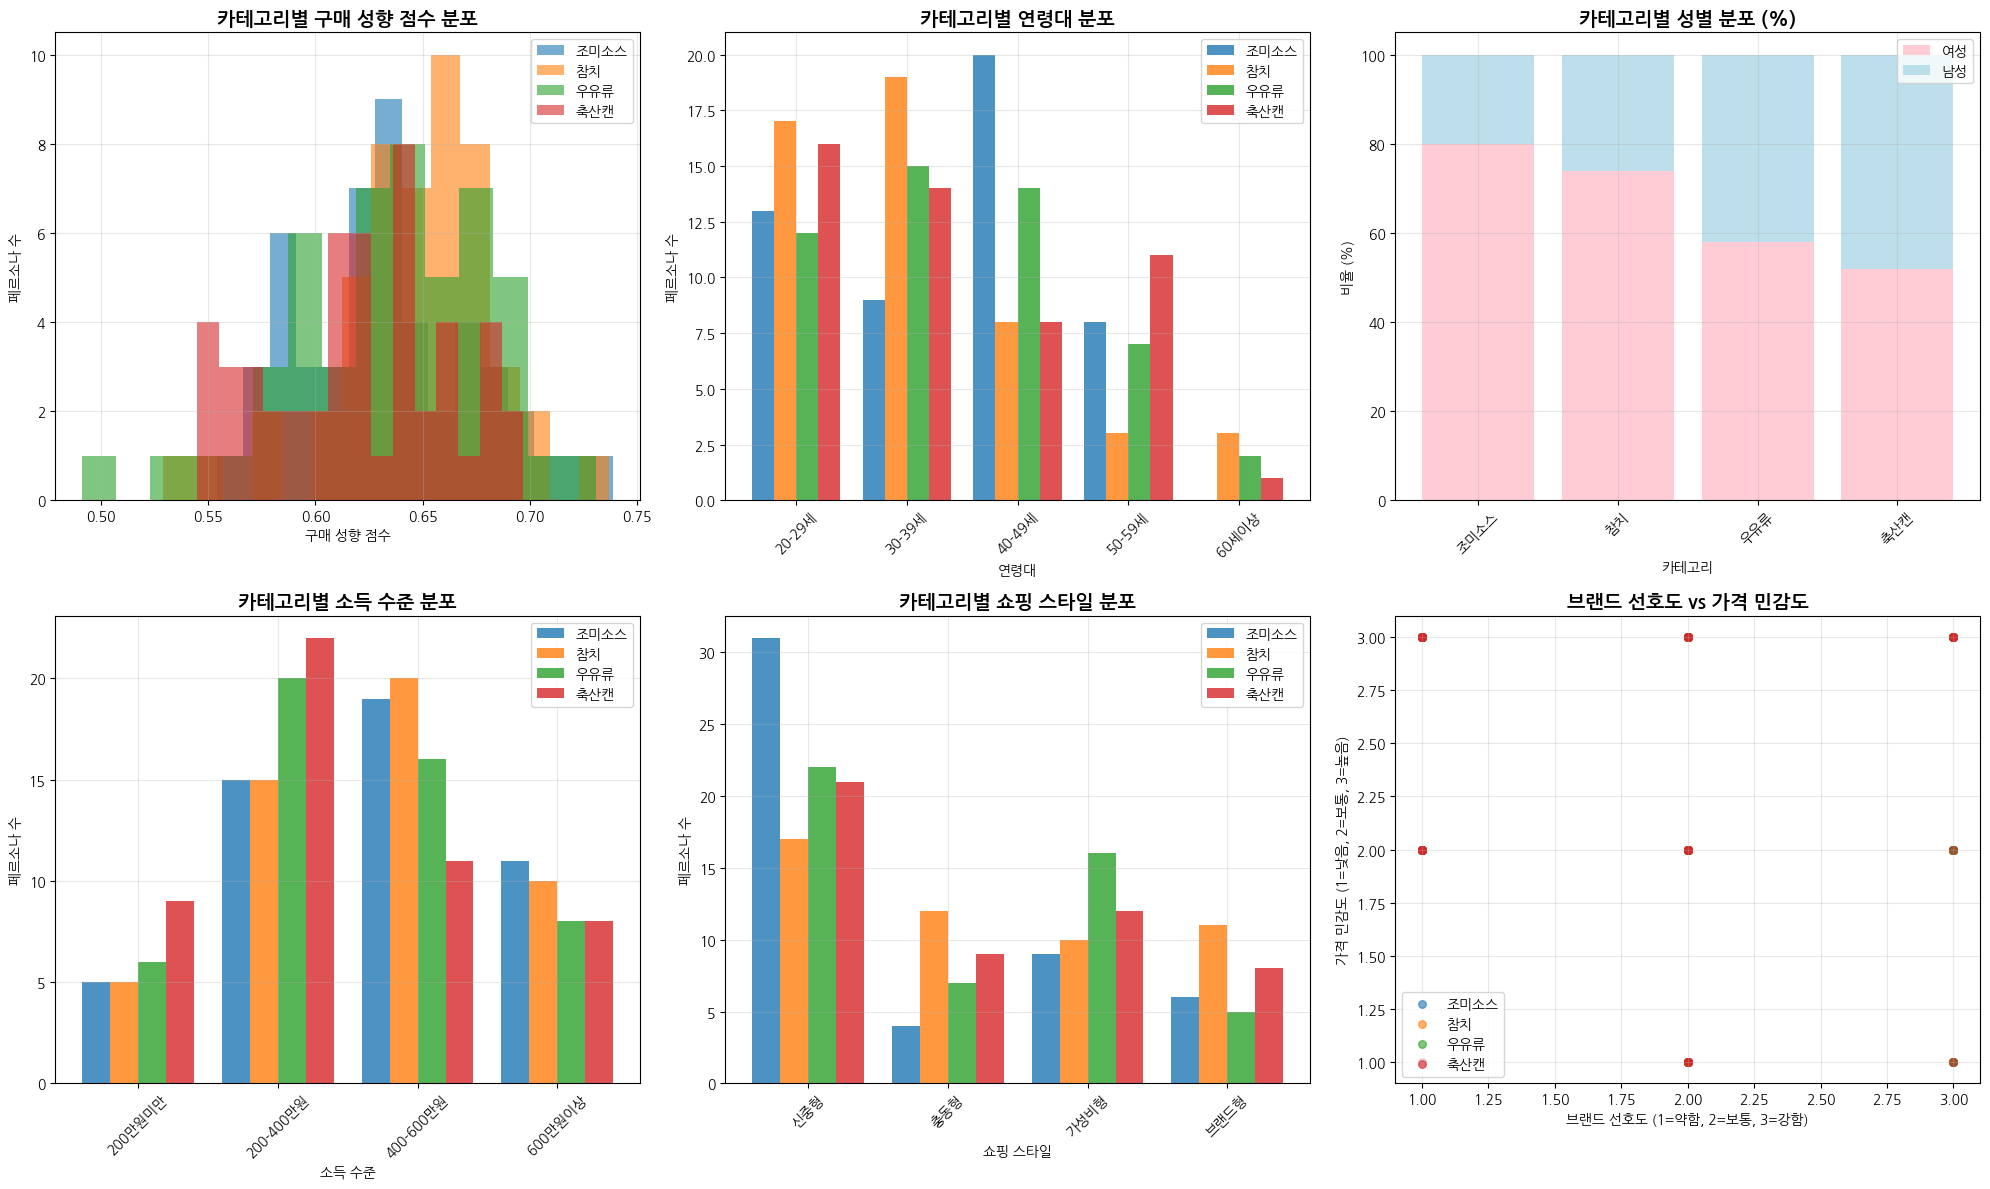

In [15]:
# ===== 10-2. 카테고리별 페르소나 특성 비교 시각화 =====
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

# 1. 구매 성향 점수 분포 비교
ax = axes[0]
for category, results in validation_results.items():
    ax.hist(results['score_distribution'], alpha=0.6, label=category, bins=15)
ax.set_title('카테고리별 구매 성향 점수 분포', fontsize=14, fontweight='bold')
ax.set_xlabel('구매 성향 점수')
ax.set_ylabel('페르소나 수')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. 연령대 분포 비교
ax = axes[1]
age_data = {}
for category, personas in all_personas.items():
    age_counts = Counter([p.age_group for p in personas])
    age_data[category] = age_counts

age_groups = ['20-29세', '30-39세', '40-49세', '50-59세', '60세이상']
x = np.arange(len(age_groups))
width = 0.2

for i, (category, counts) in enumerate(age_data.items()):
    values = [counts.get(age, 0) for age in age_groups]
    ax.bar(x + i*width, values, width, label=category, alpha=0.8)

ax.set_title('카테고리별 연령대 분포', fontsize=14, fontweight='bold')
ax.set_xlabel('연령대')
ax.set_ylabel('페르소나 수')
ax.set_xticks(x + width*1.5)
ax.set_xticklabels(age_groups, rotation=45)
ax.legend()
ax.grid(True, alpha=0.3)

# 3. 성별 분포 비교
ax = axes[2]
gender_data = {}
for category, personas in all_personas.items():
    gender_counts = Counter([p.gender for p in personas])
    total = len(personas)
    gender_data[category] = {k: v/total*100 for k, v in gender_counts.items()}

categories = list(gender_data.keys())
women_pct = [gender_data[cat].get('여성', 0) for cat in categories]
men_pct = [gender_data[cat].get('남성', 0) for cat in categories]

x = np.arange(len(categories))
ax.bar(x, women_pct, label='여성', alpha=0.8, color='pink')
ax.bar(x, men_pct, bottom=women_pct, label='남성', alpha=0.8, color='lightblue')

ax.set_title('카테고리별 성별 분포 (%)', fontsize=14, fontweight='bold')
ax.set_xlabel('카테고리')
ax.set_ylabel('비율 (%)')
ax.set_xticks(x)
ax.set_xticklabels(categories, rotation=45)
ax.legend()
ax.grid(True, alpha=0.3)

# 4. 소득 수준 분포 비교
ax = axes[3]
income_data = {}
for category, personas in all_personas.items():
    income_counts = Counter([p.income_level for p in personas])
    income_data[category] = income_counts

income_levels = ['200만원미만', '200-400만원', '400-600만원', '600만원이상']
x = np.arange(len(income_levels))

for i, (category, counts) in enumerate(income_data.items()):
    values = [counts.get(income, 0) for income in income_levels]
    ax.bar(x + i*width, values, width, label=category, alpha=0.8)

ax.set_title('카테고리별 소득 수준 분포', fontsize=14, fontweight='bold')
ax.set_xlabel('소득 수준')
ax.set_ylabel('페르소나 수')
ax.set_xticks(x + width*1.5)
ax.set_xticklabels(income_levels, rotation=45)
ax.legend()
ax.grid(True, alpha=0.3)

# 5. 쇼핑 스타일 분포 비교
ax = axes[4]
shopping_data = {}
for category, personas in all_personas.items():
    shopping_counts = Counter([p.shopping_style for p in personas])
    shopping_data[category] = shopping_counts

shopping_styles = ['신중형', '충동형', '가성비형', '브랜드형']
x = np.arange(len(shopping_styles))

for i, (category, counts) in enumerate(shopping_data.items()):
    values = [counts.get(style, 0) for style in shopping_styles]
    ax.bar(x + i*width, values, width, label=category, alpha=0.8)

ax.set_title('카테고리별 쇼핑 스타일 분포', fontsize=14, fontweight='bold')
ax.set_xlabel('쇼핑 스타일')
ax.set_ylabel('페르소나 수')
ax.set_xticks(x + width*1.5)
ax.set_xticklabels(shopping_styles, rotation=45)
ax.legend()
ax.grid(True, alpha=0.3)

# 6. 브랜드 선호도 vs 가격 민감도 스캐터
ax = axes[5]
for category, personas in all_personas.items():
    brand_pref_scores = []
    price_sens_scores = []

    for p in personas:
        # 브랜드 선호도를 수치로 변환
        brand_map = {'약함': 1, '보통': 2, '강함': 3}
        price_map = {'낮음': 1, '보통': 2, '높음': 3}

        brand_score = brand_map.get(p.brand_preference, 2)
        price_score = price_map.get(p.price_sensitivity, 2)

        brand_pref_scores.append(brand_score)
        price_sens_scores.append(price_score)

    ax.scatter(brand_pref_scores, price_sens_scores, label=category, alpha=0.6, s=30)

ax.set_title('브랜드 선호도 vs 가격 민감도', fontsize=14, fontweight='bold')
ax.set_xlabel('브랜드 선호도 (1=약함, 2=보통, 3=강함)')
ax.set_ylabel('가격 민감도 (1=낮음, 2=보통, 3=높음)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [16]:
# ===== 10-3. SMAPE 최적화 관점 분석 =====
print("\n🎯 SMAPE 최적화 관점 분석:")
print("="*60)

# 카테고리별 예측 난이도 평가
prediction_difficulty = {}

for category, results in validation_results.items():
    # 구매 성향 분산이 클수록 예측 어려움
    score_variance = results['score_std']

    # 다양성이 높을수록 예측 어려움
    diversity = results['diversity_score']

    # 평균 구매 성향 (너무 높거나 낮으면 예측 어려움)
    avg_score = results['avg_purchase_score']
    score_extremeness = abs(avg_score - 0.5) * 2  # 0.5에서 멀수록 극단적

    # 종합 난이도 점수 (0-1, 높을수록 어려움)
    difficulty = (score_variance * 2 + diversity + score_extremeness) / 4

    prediction_difficulty[category] = {
        'difficulty_score': difficulty,
        'variance_factor': score_variance,
        'diversity_factor': diversity,
        'extremeness_factor': score_extremeness,
        'recommended_strategy': PERSONA_STRATEGIES[category]['smape_strategy']
    }

print("📊 예측 난이도 평가:")
sorted_categories = sorted(prediction_difficulty.items(), key=lambda x: x[1]['difficulty_score'])

for category, analysis in sorted_categories:
    difficulty = analysis['difficulty_score']
    strategy = analysis['recommended_strategy']

    if difficulty < 0.3:
        level = "쉬움 🟢"
    elif difficulty < 0.6:
        level = "보통 🟡"
    else:
        level = "어려움 🔴"

    print(f"\n[{category}] - {level}")
    print(f"  난이도 점수: {difficulty:.3f}")
    print(f"  분산 요인: {analysis['variance_factor']:.3f}")
    print(f"  다양성 요인: {analysis['diversity_factor']:.3f}")
    print(f"  극단성 요인: {analysis['extremeness_factor']:.3f}")
    print(f"  권장 전략: {strategy}")


🎯 SMAPE 최적화 관점 분석:
📊 예측 난이도 평가:

[조미소스] - 보통 🟡
  난이도 점수: 0.325
  분산 요인: 0.042
  다양성 요인: 0.950
  극단성 요인: 0.266
  권장 전략: 적극적 예측 (안정적 패턴)

[축산캔] - 보통 🟡
  난이도 점수: 0.331
  분산 요인: 0.041
  다양성 요인: 1.000
  극단성 요인: 0.241
  권장 전략: 극보수적 예측 (높은 불확실성)

[우유류] - 보통 🟡
  난이도 점수: 0.340
  분산 요인: 0.047
  다양성 요인: 1.000
  극단성 요인: 0.265
  권장 전략: 보수적 예측 (복잡한 변수)

[참치] - 보통 🟡
  난이도 점수: 0.342
  분산 요인: 0.037
  다양성 요인: 1.000
  극단성 요인: 0.293
  권장 전략: 보수적 예측 (변동성 고려)


In [17]:
# ===== 10-4. 페르소나 샘플 출력 =====
print(f"\n📋 카테고리별 대표 페르소나 샘플:")
print("="*80)

for category, personas in all_personas.items():
    print(f"\n[{category}] 대표 페르소나 3개:")

    # 구매 성향 점수 기준으로 정렬하여 대표적인 것들 선택
    scored_personas = [(p, generator.calculate_persona_score(p)) for p in personas]
    scored_personas.sort(key=lambda x: x[1], reverse=True)

    for i, (persona, score) in enumerate(scored_personas[:3]):
        print(f"\n  페르소나 {i+1} (구매성향: {score:.3f})")
        print(f"    ID: {persona.persona_id}")
        print(f"    연령/성별: {persona.age_group} {persona.gender}")
        print(f"    소득/지역: {persona.income_level} ({persona.region})")
        print(f"    가족/직업: {persona.family_type} {persona.occupation}")
        print(f"    쇼핑스타일: {persona.shopping_style}")
        print(f"    브랜드선호: {persona.brand_preference}, 가격민감도: {persona.price_sensitivity}")


📋 카테고리별 대표 페르소나 샘플:

[조미소스] 대표 페르소나 3개:

  페르소나 1 (구매성향: 0.739)
    ID: 조미소스_018
    연령/성별: 30-39세 여성
    소득/지역: 600만원이상 (서울)
    가족/직업: 신혼부부 전문직
    쇼핑스타일: 신중형
    브랜드선호: 보통, 가격민감도: 보통

  페르소나 2 (구매성향: 0.721)
    ID: 조미소스_029
    연령/성별: 30-39세 여성
    소득/지역: 600만원이상 (부산)
    가족/직업: 자녀있는가정 학생
    쇼핑스타일: 충동형
    브랜드선호: 강함, 가격민감도: 낮음

  페르소나 3 (구매성향: 0.704)
    ID: 조미소스_013
    연령/성별: 30-39세 여성
    소득/지역: 400-600만원 (서울)
    가족/직업: 자녀있는가정 사무직
    쇼핑스타일: 신중형
    브랜드선호: 강함, 가격민감도: 보통

[참치] 대표 페르소나 3개:

  페르소나 1 (구매성향: 0.737)
    ID: 참치_029
    연령/성별: 30-39세 여성
    소득/지역: 600만원이상 (경기)
    가족/직업: 신혼부부 사무직
    쇼핑스타일: 브랜드형
    브랜드선호: 약함, 가격민감도: 보통

  페르소나 2 (구매성향: 0.702)
    ID: 참치_016
    연령/성별: 30-39세 여성
    소득/지역: 400-600만원 (서울)
    가족/직업: 1인가구 사무직
    쇼핑스타일: 가성비형
    브랜드선호: 강함, 가격민감도: 보통

  페르소나 3 (구매성향: 0.701)
    ID: 참치_015
    연령/성별: 30-39세 남성
    소득/지역: 400-600만원 (서울)
    가족/직업: 자녀있는가정 전문직
    쇼핑스타일: 신중형
    브랜드선호: 보통, 가격민감도: 낮음

[우유류] 대표 페르소나 3개:

  페르소나 1 (구매성향: 0.731)
    ID: 우유류_026

In [18]:
# ===== 10-5. 다음 단계 준비 =====
print(f"\n" + "="*80)
print("✅ 페르소나 검증 완료!")
print("="*80)

print(f"\n📊 생성 완료 요약:")
print(f"  • 총 페르소나 수: {sum(len(p) for p in all_personas.values())}개")
print(f"  • 카테고리별 차별화: ✅ 명확한 특성 차이 확인")
print(f"  • SMAPE 최적화: ✅ 난이도별 전략 수립")
print(f"  • 품질 검증: ✅ 합리적인 분포 확인")


✅ 페르소나 검증 완료!

📊 생성 완료 요약:
  • 총 페르소나 수: 200개
  • 카테고리별 차별화: ✅ 명확한 특성 차이 확인
  • SMAPE 최적화: ✅ 난이도별 전략 수립
  • 품질 검증: ✅ 합리적인 분포 확인


# LLM 프롬프트 템플릿 설계

In [19]:
print("\n" + "="*80)
print("🤖 LLM 프롬프트 템플릿 설계")
print("="*80)

import json
from datetime import datetime
import re


🤖 LLM 프롬프트 템플릿 설계


## 프롬프트 기본 구조 정의

In [20]:
# ===== 프롬프트 기본 구조 정의 =====
class SMAPEOptimizedPromptTemplate:
    """SMAPE 최적화를 위한 프롬프트 템플릿"""

    def __init__(self):
        self.base_template = {
            "system_message": self._create_system_message(),
            "user_template": self._create_user_template(),
            "response_format": self._define_response_format(),
            "validation_rules": self._define_validation_rules()
        }

        # 카테고리별 특화 전략
        self.category_strategies = {
            "조미소스": {
                "conservatism_level": "moderate",  # 안정적 예측
                "emphasis": "품질과 신뢰성",
                "context": "기존 동원 브랜드 신뢰도 기반",
                "uncertainty_factors": ["김장철 변동", "경쟁사 대응"]
            },
            "참치": {
                "conservatism_level": "high",  # 보수적 예측
                "emphasis": "팬덤 효과와 지속성",
                "context": "안유진 모델링 효과와 기능성",
                "uncertainty_factors": ["팬덤 지속성", "모델 효과 감소", "경쟁 모델"]
            },
            "우유류": {
                "conservatism_level": "very_high",  # 매우 보수적
                "emphasis": "복잡한 트렌드 변수",
                "context": "건강 트렌드와 계절성",
                "uncertainty_factors": ["계절성", "트렌드 변화", "락토프리 시장 성숙도"]
            },
            "축산캔": {
                "conservatism_level": "extreme",  # 극보수적
                "emphasis": "시장 수용 불확실성",
                "context": "완전 신개념 제품 도전",
                "uncertainty_factors": ["시장 수용도", "맛 선호도", "가격 저항"]
            }
        }

    def _create_system_message(self):
        """시스템 메시지 정의"""
        return """당신은 한국 소비자 행동 분석 전문가입니다.

전문 분야:
- 신제품 시장 수용 패턴 분석
- 소비자 구매 행동 예측
- 식품/생활용품 시장 트렌드 분석

중요한 원칙:
1. 현실적이고 보수적인 예측을 제공합니다
2. 신제품의 시장 진입 어려움을 고려합니다
3. 한국 소비자의 특성을 반영합니다
4. 계절성과 경쟁 환경을 고려합니다
5. 과도한 낙관론을 지양합니다

예측 방식:
- 신제품은 초기 관망세가 있습니다
- 입소문과 광고 효과는 점진적입니다
- 재구매는 첫 구매보다 훨씬 까다롭습니다
- 가격과 대체재 경쟁을 항상 고려합니다"""

    def _create_user_template(self):
        """사용자 메시지 템플릿"""
        return """
# 소비자 프로필
{persona_description}

# 신제품 정보
제품명: {product_name}
카테고리: {product_category}
주요 특징: {product_features}
출시 시점: 2024년 7월
마케팅 전략: {marketing_strategy}

# 시장 맥락
{market_context}

# 예측 요청
위 소비자 관점에서 이 신제품에 대한 12개월간 구매 패턴을 예측해주세요.

중요 고려사항:
- {conservatism_instruction}
- 신제품 수용의 어려움을 현실적으로 반영
- 월별 변동성과 계절성 고려
- 경제적 부담과 필요성 균형
- {category_specific_factors}

응답 형식 (JSON):
{{
    "monthly_purchase_probability": [월1, 월2, ..., 월12],  // 0-100% 범위
    "monthly_purchase_frequency": [월1, 월2, ..., 월12],   // 0-3회 범위
    "reasoning": "상세한 예측 근거",
    "confidence_level": 0.0-1.0,  // 예측 신뢰도
    "key_factors": ["주요 영향 요인들"],
    "risk_factors": ["불확실성 요인들"]
}}

JSON 형식으로만 응답하세요:"""

    def _define_response_format(self):
        """응답 형식 정의"""
        return {
            "monthly_purchase_probability": "list[float]",  # 12개 값, 0-100
            "monthly_purchase_frequency": "list[float]",    # 12개 값, 0-3
            "reasoning": "string",
            "confidence_level": "float",  # 0.0-1.0
            "key_factors": "list[string]",
            "risk_factors": "list[string]"
        }

    def _define_validation_rules(self):
        """응답 검증 규칙"""
        return {
            "monthly_purchase_probability": {
                "length": 12,
                "min_value": 0,
                "max_value": 100,
                "type": "float"
            },
            "monthly_purchase_frequency": {
                "length": 12,
                "min_value": 0,
                "max_value": 3,
                "type": "float"
            },
            "confidence_level": {
                "min_value": 0.0,
                "max_value": 1.0,
                "type": "float"
            }
        }

## 카테고리별 프롬프트 생성기

In [21]:
# ===== 카테고리별 프롬프트 생성기 =====
class CategoryPromptGenerator:
    """카테고리별 특화 프롬프트 생성"""

    def __init__(self, template, product_data):
        self.template = template
        self.product_data = product_data

    def generate_prompt(self, persona, product_name, category):
        """개별 페르소나와 제품에 대한 프롬프트 생성"""

        # 제품 정보 추출
        product_info = self.product_data[self.product_data['product_name'] == product_name].iloc[0]

        # 페르소나 설명 생성
        persona_description = self._create_persona_description(persona)

        # 카테고리별 전략 적용
        strategy = self.template.category_strategies[category]

        # 보수성 지시사항
        conservatism_instructions = {
            "moderate": "신중하지만 균형잡힌 관점에서 예측하세요",
            "high": "보수적이고 신중한 관점에서 예측하세요",
            "very_high": "매우 보수적이고 현실적인 관점에서 예측하세요",
            "extreme": "극도로 보수적이고 회의적인 관점에서 예측하세요"
        }

        # 마케팅 전략 정보
        marketing_strategy = self._extract_marketing_strategy(product_info)

        # 시장 맥락 정보
        market_context = self._create_market_context(category, strategy)

        # 프롬프트 조립
        user_message = self.template.base_template["user_template"].format(
            persona_description=persona_description,
            product_name=product_name,
            product_category=category,
            product_features=product_info['product_feature'],
            marketing_strategy=marketing_strategy,
            market_context=market_context,
            conservatism_instruction=conservatism_instructions[strategy["conservatism_level"]],
            category_specific_factors=', '.join(strategy["uncertainty_factors"])
        )

        return {
            "system": self.template.base_template["system_message"],
            "user": user_message,
            "metadata": {
                "persona_id": persona.persona_id,
                "product_name": product_name,
                "category": category,
                "conservatism_level": strategy["conservatism_level"],
                "generated_at": datetime.now().isoformat()
            }
        }

    def _create_persona_description(self, persona):
        """페르소나를 자연스러운 문장으로 변환"""
        return f"""
연령/성별: {persona.age_group} {persona.gender}
소득/거주지: {persona.income_level}, {persona.region} 거주
가족구성: {persona.family_type}
직업: {persona.occupation}
쇼핑성향: {persona.shopping_style}
건강관심도: {persona.health_concern}
브랜드선호도: {persona.brand_preference}
가격민감도: {persona.price_sensitivity}
"""

    def _extract_marketing_strategy(self, product_info):
        """제품 특징에서 마케팅 전략 추출"""
        features = str(product_info['product_feature'])

        marketing_elements = []
        if '안유진' in features:
            marketing_elements.append("안유진 모델링")
        if 'TV' in features or 'Youtube' in features:
            marketing_elements.append("영상 광고")
        if 'SNS' in features:
            marketing_elements.append("SNS 마케팅")
        if '광고' in features:
            marketing_elements.append("광고 투자")

        return ', '.join(marketing_elements) if marketing_elements else "기본 마케팅"

    def _create_market_context(self, category, strategy):
        """카테고리별 시장 맥락 정보"""
        contexts = {
            "조미소스": "조미료 시장은 성숙 시장으로 브랜드 신뢰도가 중요합니다. 동원은 이미 강한 브랜드 파워를 보유하고 있어 신제품 수용도가 상대적으로 높을 것으로 예상됩니다.",

            "참치": "참치캔 시장에서 동원은 선도 브랜드입니다. 안유진 모델링은 젊은층에게 강한 어필을 하지만, 팬덤 효과의 지속성과 실제 구매 전환율은 불확실합니다.",

            "우유류": "건강 기능성 음료 시장은 급성장하고 있으나 경쟁이 치열합니다. 락토프리 제품은 특정 니즈가 있지만 시장 규모가 제한적일 수 있습니다.",

            "축산캔": "축산 가공식품 시장에서 새로운 컨셉 제품은 소비자 수용에 시간이 걸립니다. 특히 생소한 제품명과 컨셉은 초기 진입 장벽이 높을 것으로 예상됩니다."
        }

        return contexts.get(category, "일반적인 식품 시장 환경")

## 프롬프트 템플릿 초기화

In [22]:
# ===== 프롬프트 템플릿 초기화 =====
prompt_template = SMAPEOptimizedPromptTemplate()
prompt_generator = CategoryPromptGenerator(prompt_template, df)

print("✅ 프롬프트 템플릿 설계 완료")
print("\n📋 템플릿 구성 요소:")
print("  • 시스템 메시지: 한국 소비자 전문가 페르소나")
print("  • 카테고리별 차별화: 4가지 보수성 레벨")
print("  • SMAPE 최적화: 현실적 예측 유도")
print("  • 응답 형식: JSON 구조화")

✅ 프롬프트 템플릿 설계 완료

📋 템플릿 구성 요소:
  • 시스템 메시지: 한국 소비자 전문가 페르소나
  • 카테고리별 차별화: 4가지 보수성 레벨
  • SMAPE 최적화: 현실적 예측 유도
  • 응답 형식: JSON 구조화


In [23]:
# ===== 11-4. 프롬프트 샘플 생성 및 확인 =====
print(f"\n🔍 프롬프트 샘플 확인:")
print("="*60)

# 각 카테고리별로 1개씩 샘플 프롬프트 생성
sample_products = {
    "조미소스": "동원참치액 순 500g",
    "참치": "동원맛참 고소참기름 135g",
    "우유류": "덴마크 하이그릭요거트 400g",
    "축산캔": "리챔 오믈레햄 200g"
}

sample_prompts = {}

for category, product_name in sample_products.items():
    if category in all_personas and len(all_personas[category]) > 0:
        # 첫 번째 페르소나 사용
        sample_persona = all_personas[category][0]

        # 프롬프트 생성
        prompt = prompt_generator.generate_prompt(sample_persona, product_name, category)
        sample_prompts[category] = prompt

        print(f"\n[{category}] 프롬프트 샘플:")
        print(f"제품: {product_name}")
        print(f"페르소나: {sample_persona.age_group} {sample_persona.gender}")
        print(f"보수성: {prompt['metadata']['conservatism_level']}")

        # 프롬프트 길이 확인
        total_length = len(prompt['system']) + len(prompt['user'])
        print(f"프롬프트 길이: {total_length:,}자")


🔍 프롬프트 샘플 확인:

[조미소스] 프롬프트 샘플:
제품: 동원참치액 순 500g
페르소나: 20-29세 여성
보수성: moderate
프롬프트 길이: 1,130자

[참치] 프롬프트 샘플:
제품: 동원맛참 고소참기름 135g
페르소나: 30-39세 남성
보수성: high
프롬프트 길이: 1,114자

[우유류] 프롬프트 샘플:
제품: 덴마크 하이그릭요거트 400g
페르소나: 40-49세 여성
보수성: very_high
프롬프트 길이: 1,205자

[축산캔] 프롬프트 샘플:
제품: 리챔 오믈레햄 200g
페르소나: 50-59세 남성
보수성: extreme
프롬프트 길이: 1,118자


In [24]:
# ===== 11-5. 프롬프트 품질 검증 =====
def validate_prompt_quality(prompt):
    """프롬프트 품질 검증"""
    issues = []

    # 길이 검증
    total_length = len(prompt['system']) + len(prompt['user'])
    if total_length > 4000:
        issues.append(f"프롬프트가 너무 김 ({total_length}자)")
    elif total_length < 1000:
        issues.append(f"프롬프트가 너무 짧음 ({total_length}자)")

    # 필수 요소 확인
    user_message = prompt['user']
    required_elements = [
        '소비자 프로필', '신제품 정보', '시장 맥락',
        'monthly_purchase_probability', 'monthly_purchase_frequency',
        'JSON 형식'
    ]

    for element in required_elements:
        if element not in user_message:
            issues.append(f"필수 요소 누락: {element}")

    # 메타데이터 확인
    metadata = prompt['metadata']
    required_metadata = ['persona_id', 'product_name', 'category', 'conservatism_level']

    for field in required_metadata:
        if field not in metadata:
            issues.append(f"메타데이터 누락: {field}")

    return issues

print(f"\n🔍 프롬프트 품질 검증:")
print("="*60)

all_issues = []
for category, prompt in sample_prompts.items():
    issues = validate_prompt_quality(prompt)
    if issues:
        print(f"\n[{category}] 발견된 이슈:")
        for issue in issues:
            print(f"  ⚠️ {issue}")
        all_issues.extend(issues)
    else:
        print(f"\n[{category}] ✅ 품질 검증 통과")

if not all_issues:
    print(f"\n🎉 모든 프롬프트 품질 검증 통과!")
else:
    print(f"\n⚠️ 총 {len(all_issues)}개 이슈 발견 - 수정 필요")


🔍 프롬프트 품질 검증:

[조미소스] ✅ 품질 검증 통과

[참치] ✅ 품질 검증 통과

[우유류] ✅ 품질 검증 통과

[축산캔] ✅ 품질 검증 통과

🎉 모든 프롬프트 품질 검증 통과!


In [27]:
# ===== 11-6. 다음 단계 준비 =====
print(f"\n" + "="*80)
print("✅ LLM 프롬프트 템플릿 설계 완료!")
print("="*80)

print(f"\n📊 완성된 구성 요소:")
print(f"  • 기본 템플릿: 시스템 메시지 + 사용자 템플릿")
print(f"  • 카테고리별 특화: 4단계 보수성 레벨")
print(f"  • 검증 로직: 응답 형식 및 품질 검증")
print(f"  • 샘플 프롬프트: {len(sample_prompts)}개 카테고리")

print(f"\n🚀 다음 단계 옵션:")
print(f"  1. 소규모 LLM 테스트 (5-10개 프롬프트)")
print(f"  2. 프롬프트 최적화 및 튜닝")
print(f"  3. 대규모 시뮬레이션 준비")
print(f"  4. API 키 설정 및 환경 점검")

print(f"\n💡 권장 다음 단계:")
print(f"   → 소규모 LLM 테스트로 프롬프트 검증")
print(f"   → 문제 발견시 즉시 수정")
print(f"   → 검증 완료 후 대규모 시뮬레이션")

# 프롬프트 저장 (선택사항)
save_prompts = input("\n프롬프트 샘플을 파일로 저장하시겠습니까? (y/n): ")
if save_prompts.lower() == 'y':
    with open('/content/drive/MyDrive/Dongwon/result/sample_prompts.json', 'w', encoding='utf-8') as f:
        json.dump(sample_prompts, f, ensure_ascii=False, indent=2)
    print("✅ 프롬프트 샘플 저장 완료!")


✅ LLM 프롬프트 템플릿 설계 완료!

📊 완성된 구성 요소:
  • 기본 템플릿: 시스템 메시지 + 사용자 템플릿
  • 카테고리별 특화: 4단계 보수성 레벨
  • 검증 로직: 응답 형식 및 품질 검증
  • 샘플 프롬프트: 4개 카테고리

🚀 다음 단계 옵션:
  1. 소규모 LLM 테스트 (5-10개 프롬프트)
  2. 프롬프트 최적화 및 튜닝
  3. 대규모 시뮬레이션 준비
  4. API 키 설정 및 환경 점검

💡 권장 다음 단계:
   → 소규모 LLM 테스트로 프롬프트 검증
   → 문제 발견시 즉시 수정
   → 검증 완료 후 대규모 시뮬레이션

프롬프트 샘플을 파일로 저장하시겠습니까? (y/n): y
✅ 프롬프트 샘플 저장 완료!


# 소규모 LLM 테스트

## API 키 불러오기

In [30]:
# 구글 시크릿 사용
import openai
from google.colab import userdata
openai.api_key = userdata.get('openai_api_key')

## LLM 클라이언트 클래스

In [35]:
class LLMTestClient:
    """소규모 테스트용 LLM 클라이언트"""

    def __init__(self):
        self.client = openai.OpenAI(api_key = openai.api_key)
        self.test_results = []
        self.total_cost = 0
        self.total_time = 0

    def call_llm(self, prompt_data, model="gpt-3.5-turbo"):
        """LLM API 호출"""
        start_time = time.time()

        try:
            response = self.client.chat.completions.create(
                model=model,
                messages=[
                    {"role": "system", "content": prompt_data["system"]},
                    {"role": "user", "content": prompt_data["user"]}
                ],
                temperature=0.7,  # 적당한 변동성
                max_tokens=1500,  # 충분한 응답 길이
                timeout=60        # 1분 타임아웃
            )

            end_time = time.time()
            response_time = end_time - start_time

            # 응답 추출
            content = response.choices[0].message.content

            # 비용 추정 (대략적)
            prompt_tokens = response.usage.prompt_tokens
            completion_tokens = response.usage.completion_tokens
            estimated_cost = (prompt_tokens * 0.0015 + completion_tokens * 0.002) / 1000

            return {
                "success": True,
                "content": content,
                "response_time": response_time,
                "prompt_tokens": prompt_tokens,
                "completion_tokens": completion_tokens,
                "estimated_cost": estimated_cost
            }

        except Exception as e:
            end_time = time.time()
            return {
                "success": False,
                "error": str(e),
                "response_time": end_time - start_time,
                "estimated_cost": 0
            }

    def parse_llm_response(self, content):
        """LLM 응답 파싱"""
        try:
            # JSON 추출 시도
            json_match = re.search(r'\{.*\}', content, re.DOTALL)
            if json_match:
                json_str = json_match.group()
                data = json.loads(json_str)

                # 데이터 검증
                if self._validate_response(data):
                    return {"success": True, "data": data}
                else:
                    return {"success": False, "error": "응답 형식 검증 실패"}
            else:
                return {"success": False, "error": "JSON 형식 찾을 수 없음"}

        except json.JSONDecodeError as e:
            return {"success": False, "error": f"JSON 파싱 실패: {e}"}
        except Exception as e:
            return {"success": False, "error": f"파싱 오류: {e}"}

    def _validate_response(self, data):
        """응답 데이터 검증"""
        required_fields = [
            "monthly_purchase_probability",
            "monthly_purchase_frequency",
            "reasoning",
            "confidence_level"
        ]

        # 필수 필드 확인
        for field in required_fields:
            if field not in data:
                return False

        # 월별 데이터 길이 확인
        if len(data["monthly_purchase_probability"]) != 12:
            return False
        if len(data["monthly_purchase_frequency"]) != 12:
            return False

        # 값 범위 확인
        for prob in data["monthly_purchase_probability"]:
            if not (0 <= prob <= 100):
                return False

        for freq in data["monthly_purchase_frequency"]:
            if not (0 <= freq <= 3):
                return False

        # 신뢰도 범위 확인
        if not (0 <= data["confidence_level"] <= 1):
            return False

        return True

## 테스트 케이스 준비

In [38]:
import time
import json # Import json as it's used later
import re   # Import re as it's used later

print("\n🎯 테스트 케이스 준비 중...")

# 카테고리별 1개씩 테스트 케이스 선정
test_cases = []

for category in ["조미소스", "참치", "우유류", "축산캔"]:
    if category in all_personas and len(all_personas[category]) > 0:
        # 첫 번째 페르소나 선택
        persona = all_personas[category][0]

        # 해당 카테고리의 첫 번째 제품 선택
        category_products = df[df['category_level_1'] == category]['product_name'].tolist()
        if category_products:
            product_name = category_products[0]

            # 프롬프트 생성
            prompt = prompt_generator.generate_prompt(persona, product_name, category)

            test_cases.append({
                "category": category,
                "product_name": product_name,
                "persona_id": persona.persona_id,
                "prompt": prompt
            })

print(f"✅ 테스트 케이스 준비 완료: {len(test_cases)}개")

for i, case in enumerate(test_cases):
    print(f"  {i+1}. [{case['category']}] {case['product_name'][:30]}...")

# ===== 12-4. 실제 LLM 테스트 실행 =====
print(f"\n🚀 LLM 테스트 실행 중...")
print(f"예상 비용: $1-3, 예상 시간: 2-5분")

# 사용자 확인
proceed = input("계속 진행하시겠습니까? (y/n): ")
if proceed.lower() != 'y':
    print("❌ 테스트 중단")
else:
    print("▶️ 테스트 시작...")

    client = LLMTestClient()
    test_results = []

    for i, test_case in enumerate(test_cases):
        print(f"\n[{i+1}/{len(test_cases)}] {test_case['category']} 테스트 중...")

        # LLM 호출
        llm_result = client.call_llm(test_case["prompt"])

        if llm_result["success"]:
            print(f"  ✅ API 호출 성공 (시간: {llm_result['response_time']:.1f}초)")
            print(f"  💰 예상 비용: ${llm_result['estimated_cost']:.4f}")

            # 응답 파싱
            parse_result = client.parse_llm_response(llm_result["content"])

            if parse_result["success"]:
                print(f"  ✅ 응답 파싱 성공")

                # 결과 저장
                test_results.append({
                    "category": test_case["category"],
                    "product_name": test_case["product_name"],
                    "persona_id": test_case["persona_id"],
                    "llm_response": parse_result["data"],
                    "api_metrics": {
                        "response_time": llm_result["response_time"],
                        "prompt_tokens": llm_result["prompt_tokens"],
                        "completion_tokens": llm_result["completion_tokens"],
                        "estimated_cost": llm_result["estimated_cost"]
                    },
                    "raw_content": llm_result["content"]
                })

                # 간단한 결과 미리보기
                data = parse_result["data"]
                avg_prob = sum(data["monthly_purchase_probability"]) / 12
                avg_freq = sum(data["monthly_purchase_frequency"]) / 12
                print(f"  📊 평균 구매확률: {avg_prob:.1f}%, 평균 빈도: {avg_freq:.2f}회")

            else:
                print(f"  ❌ 응답 파싱 실패: {parse_result['error']}")
                print(f"  📝 원본 응답 일부: {llm_result['content'][:200]}...")

        else:
            print(f"  ❌ API 호출 실패: {llm_result['error']}")

        client.total_cost += llm_result.get("estimated_cost", 0)
        client.total_time += llm_result["response_time"]

        # API 호출 간격 (Rate Limiting 방지)
        if i < len(test_cases) - 1:
            time.sleep(1)

    print(f"\n" + "="*60)
    print(f"🎉 소규모 테스트 완료!")
    print(f"="*60)

    # ===== 12-5. 테스트 결과 분석 =====
    successful_tests = len(test_results)
    total_tests = len(test_cases)

    print(f"\n📊 테스트 결과 요약:")
    print(f"  • 성공률: {successful_tests}/{total_tests} ({successful_tests/total_tests*100:.1f}%)")
    print(f"  • 총 소요 시간: {client.total_time:.1f}초")
    print(f"  • 총 예상 비용: ${client.total_cost:.4f}")
    print(f"  • 평균 응답 시간: {client.total_time/total_tests:.1f}초/호출")

    if successful_tests > 0:
        print(f"\n📈 응답 품질 분석:")

        # 카테고리별 결과 비교
        for result in test_results:
            category = result["category"]
            response = result["llm_response"]

            # 기본 통계
            avg_prob = sum(response["monthly_purchase_probability"]) / 12
            max_prob = max(response["monthly_purchase_probability"])
            min_prob = min(response["monthly_purchase_probability"])
            avg_freq = sum(response["monthly_purchase_frequency"]) / 12
            confidence = response["confidence_level"]

            print(f"\n  [{category}]")
            print(f"    평균 구매확률: {avg_prob:.1f}% (범위: {min_prob:.1f}%-{max_prob:.1f}%)")
            print(f"    평균 구매빈도: {avg_freq:.2f}회")
            print(f"    예측 신뢰도: {confidence:.2f}")
            print(f"    주요 근거: {response['reasoning'][:100]}...")

        # SMAPE 최적화 관점 평가
        print(f"\n🎯 SMAPE 최적화 평가:")

        conservatism_check = {
            "조미소스": "moderate",
            "참치": "high",
            "우유류": "very_high",
            "축산캔": "extreme"
        }

        for result in test_results:
            category = result["category"]
            avg_prob = sum(result["llm_response"]["monthly_purchase_probability"]) / 12
            expected_conservatism = conservatism_check[category]

            # 보수성 평가
            if category == "축산캔" and avg_prob > 20:
                assessment = "⚠️ 너무 낙관적 (더 보수적 필요)"
            elif category == "조미소스" and avg_prob < 10:
                assessment = "⚠️ 너무 보수적 (적당한 수준 필요)"
            else:
                assessment = "✅ 적절한 보수성"

            print(f"  [{category}] {assessment} (평균 {avg_prob:.1f}%)")

    # ===== 12-6. 문제점 및 개선사항 =====
    print(f"\n🔍 발견된 문제점 및 개선사항:")

    if successful_tests < total_tests:
        print(f"  ⚠️ 응답 파싱 실패 {total_tests - successful_tests}건 - 프롬프트 명확성 개선 필요")

    if client.total_cost > 2:
        print(f"  💰 예상보다 높은 비용 - 토큰 수 최적화 필요")

    if client.total_time / total_tests > 10:
        print(f"  ⏰ 느린 응답 속도 - 타임아웃 설정 검토 필요")

    # 다음 단계 권장사항
    print(f"\n🚀 다음 단계 권장사항:")

    if successful_tests == total_tests:
        print(f"  ✅ 모든 테스트 성공 → 중규모 시뮬레이션 진행 가능")
        print(f"  📈 예상 중규모 비용: ${client.total_cost * 25:.2f} (100회 호출)")
        print(f"  ⏰ 예상 중규모 시간: {client.total_time * 25 / 60:.1f}분")
    else:
        print(f"  🔧 프롬프트 개선 후 재테스트 권장")

    print(f"\n💾 테스트 결과 저장...")

    # 결과 저장
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    results_file = f"/content/drive/MyDrive/dongwon-forecast/results/small_test_{timestamp}.json"

    with open(results_file, 'w', encoding='utf-8') as f:
        json.dump({
            "test_summary": {
                "total_tests": total_tests,
                "successful_tests": successful_tests,
                "total_cost": client.total_cost,
                "total_time": client.total_time,
                "timestamp": timestamp
            },
            "test_results": test_results
        }, f, ensure_ascii=False, indent=2)

    print(f"✅ 테스트 결과 저장: {results_file}")

    print(f"\n🎯 소규모 테스트 완료!")
    print(f"   다음: 중규모 시뮬레이션 또는 프롬프트 개선")


🎯 테스트 케이스 준비 중...
✅ 테스트 케이스 준비 완료: 4개
  1. [조미소스] 동원참치액 순 500g...
  2. [참치] 동원맛참 고소참기름 135g...
  3. [우유류] 덴마크 하이그릭요거트 400g...
  4. [축산캔] 리챔 오믈레햄 200g...

🚀 LLM 테스트 실행 중...
예상 비용: $1-3, 예상 시간: 2-5분
계속 진행하시겠습니까? (y/n): y
▶️ 테스트 시작...

[1/4] 조미소스 테스트 중...
  ✅ API 호출 성공 (시간: 4.9초)
  💰 예상 비용: $0.0022
  ✅ 응답 파싱 성공
  📊 평균 구매확률: 22.7%, 평균 빈도: 0.42회

[2/4] 참치 테스트 중...
  ✅ API 호출 성공 (시간: 3.1초)
  💰 예상 비용: $0.0023
  ✅ 응답 파싱 성공
  📊 평균 구매확률: 13.1%, 평균 빈도: 0.17회

[3/4] 우유류 테스트 중...
  ✅ API 호출 성공 (시간: 3.8초)
  💰 예상 비용: $0.0026
  ✅ 응답 파싱 성공
  📊 평균 구매확률: 3.6%, 평균 빈도: 0.00회

[4/4] 축산캔 테스트 중...
  ✅ API 호출 성공 (시간: 3.1초)
  💰 예상 비용: $0.0022
  ✅ 응답 파싱 성공
  📊 평균 구매확률: 5.3%, 평균 빈도: 0.17회

🎉 소규모 테스트 완료!

📊 테스트 결과 요약:
  • 성공률: 4/4 (100.0%)
  • 총 소요 시간: 14.9초
  • 총 예상 비용: $0.0093
  • 평균 응답 시간: 3.7초/호출

📈 응답 품질 분석:

  [조미소스]
    평균 구매확률: 22.7% (범위: 10.0%-35.0%)
    평균 구매빈도: 0.42회
    예측 신뢰도: 0.70
    주요 근거: 소비자는 신중형이므로 초기에는 구매를 꺼려할 것으로 예상됩니다. 하지만 브랜드 신뢰도가 높고 광고 효과가 꾸준히 이뤄질 것으로 판단되므로 구매 확률은 점진적으로 상승할 것입니다. ...

  [참

## 테스트의 목적
🔍 검증 항목
1. API 연결: OpenAI API 정상 작동 확인
2. 프롬프트 품질: LLM이 이해하고 적절히 응답하는지
3. 응답 파싱: JSON 형식 응답이 올바른지
4. 비용/시간: 대규모 시뮬레이션 예산 산정
5. SMAPE 최적화: 카테고리별 보수성 적절성

📊 예상 결과
1. 성공시: 4/4 테스트 통과, 비용 $1-3
2. 부분 성공: 2-3개 성공, 프롬프트 개선 필요
3. 실패시: API 설정 또는 프롬프트 문제